In [1]:
# Basic Imports
import pathlib
from pathlib import Path
import os
import sys
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union
import json
import time
from tqdm.auto import tqdm
import numpy as np
from copy import copy
from glob import glob
from collections import defaultdict
import matplotlib.pyplot as plt

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

# JAX/Flax
import jax
import jax.numpy as jnp
from jax import random
import flax
from flax import linen as nn
from flax.training import train_state, checkpoints
import optax

# For ODESolver
from scipy import integrate

# PyTorch for Dataloaders
import torch
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision import transforms


# Path to import created files
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/src")

# Import created functions
# from data import make_dataset as mkds
# from visualization import visualize as vis
# from models import train_model as tm
# from models import sampling as smp
import make_dataset as mkds
import visualization as vis

from numpy.random import default_rng
rng = default_rng(seed=42)

# 0. Create MNIST

In [2]:
# Instantiate the data loaders
train_dl, val_dl, test_dl = mkds.load_data_loaders(batch_size=128)
# Get a batch of images (batch[0]) and labels (batch[1])
batch = next(iter(train_dl))
# Assign the images to a specific variable that we'll use for training
samples_batch = batch[0]

# # # Visualize samples of the training dataloader
# vis.plot_MNIST(train_dl, 4)

# 1. Perturb the samples

In [3]:
# Create the perturbed data as described in Algorithm 2 of the paper.
# Note: y_tilde = (y, z) and data = np.concatenate(y, z) 
#                        ie. data.shape = (batchsize, imgsize**2 + 1)
x, y_tilde, data = mkds.get_perturbed(samples_batch, rng=rng, M=291)

# # # Can visualize how the different hyperparameters visually alter an MNIST sample.
# vis.visualize_single_perturbed(batch=samples_batch, sample_idx= 5, rng=rng, tau=0, M=0)

# # Can visualize how the different hyperparameters change how the MNIST samples are lifted into N+1.
# vis.perturb_scatter(samples_batch, rng, M=10)

# 2. Calculate the Poisson/empirical field "labels"

These field coordinates will become the labels we train the NN on.

**Modify `empirical_field` code, so it's clearer how the E fields are being calculated**

In [4]:
# Create the E field for every batch sample
E = mkds.empirical_field(samples_batch, rng)
x, y, data = mkds.get_perturbed(samples_batch,rng)

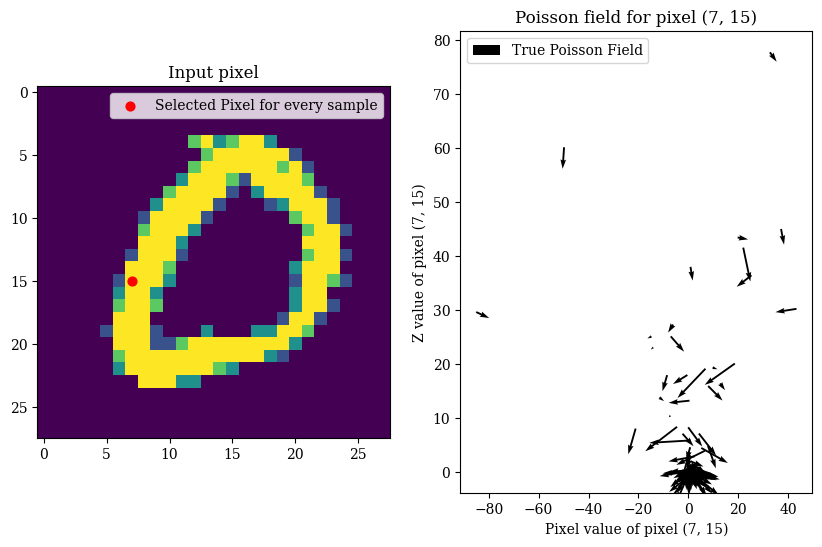

In [5]:
# Can visualize what the E field in the N+1 dimension would look like
# for a specific pixel value (red dot in left plot) 
# for the entire batch of data
vis.visualize_field(batch=samples_batch,
                sample_idx=0, 
                x_coord=7, 
                y_coord=15, 
                rng=rng, 
                set_lims=False)


In [6]:
# def sample_unit_sphere(N_dim, samples, rng):
#     x = rng.standard_normal(size=(samples, N_dim))
#     x /= np.linalg.norm(x, ord=2, axis=-1, keepdims=True)
#     return x

# rng = default_rng()
# u = sample_unit_sphere(2, 100, rng)
# plt.plot(*u.T, '.')